In [4]:
# Boilerplate at top of file
%load_ext autoreload
%load_ext rmagic
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
import math

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from ggplot import *

/usr/local/lib/python2.7/site-packages/IPython/extensions/rmagic.py:693: UserWarning: The rmagic extension in IPython is deprecated in favour of rpy2.ipython. If available, that will be loaded instead.
http://rpy.sourceforge.net/
  warnings.warn("The rmagic extension in IPython is deprecated in favour of "


In [111]:
# Load in the data
# File format uses 'YYYY-MM-DD-HH_Mi_Se'
df_1 = pd.read_csv('data/2015-10-18-14_27_35.csv')
# df_1 = pd.read_csv('data/2015-10-20-15_08_45.csv')
start_time = datetime.datetime(2015, 10, 11, 13, 47, 46)

n = len(df_1)
print start_time # start time
print start_time + datetime.timedelta(milliseconds=np.sum(df_1.time_diff)) # end time

2015-10-11 13:47:46
2015-10-11 13:50:40.633000


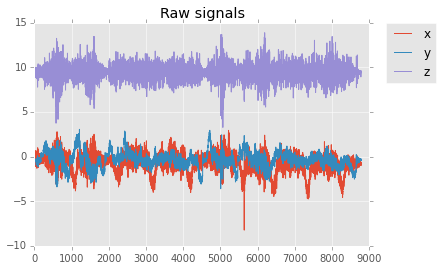

In [112]:
plt.plot(df_1['x'], label='x')
plt.plot(df_1['y'], label='y')
plt.plot(df_1['z'], label='z')
plt.title('Raw signals')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

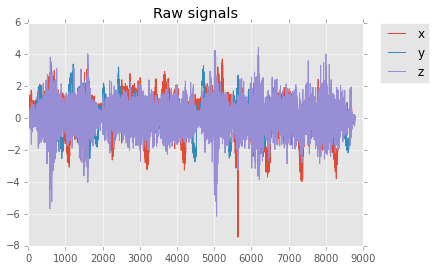

In [113]:
plt.plot(df_1['x'] - np.mean(df_1['x']), label='x')
plt.plot(df_1['y'] - np.mean(df_1['y']), label='y')
plt.plot(df_1['z'] - np.mean(df_1['z']), label='z')
plt.title('Raw signals')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

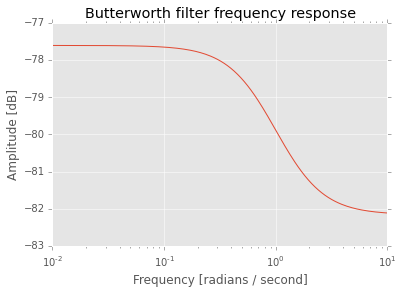

In [177]:
from scipy import signal
import math
# First, design the Buterworth filter
N  = 4   # Filter order
Wn = 0.2 / math.pi# Cutoff frequency
B, A = signal.butter(N, Wn, 'low', output='ba')
# Filter by frequency filter
# df_1['smooth_x'] = signal.filtfilt(B,A, df_1['x']) - np.mean(df_1['x'])
# df_1['smooth_y'] = signal.filtfilt(B,A, df_1['y'])- np.mean(df_1['y'])
# df_1['smooth_z'] = signal.filtfilt(B,A, df_1['z']) - np.mean(df_1['z'])
def smooth_locally(df, col, win_size):
    # Apply a local smoothing with a windo
    win = signal.hann(win_size)
    orig = df[col]
    orig = orig - np.mean(orig)
    filtered = signal.convolve(orig, win, mode='same') / sum(win)

    return filtered
# Filter with moving average
df_1['smooth_x'] = smooth_locally(df_1, 'x', 10)
df_1['smooth_y'] = smooth_locally(df_1, 'y', 10)
df_1['smooth_z'] = smooth_locally(df_1, 'z', 10)


def df_cartesian_to_polar(df, x_col, y_col, z_col):
    x = df[x_col]
    y = df[y_col]
    z = df[z_col]
    r = np.sqrt(np.power(x,2) + np.power(z,2) + np.power(y,2))
    theta = np.arccos(x / np.sqrt(np.power(x,2) + np.power(y,2)))
    phi = np.arccos(x / np.sqrt(np.power(x,2) + np.power(z,2)))
    return [r, theta, phi]
# Put acceleration in Polar coordiantes
r, theta, phi = df_cartesian_to_polar(df_1, 'smooth_x', 'smooth_y', 'smooth_z')                
df_1['accel_radius'] = r
df_1['accel_theta'] = theta
df_1['accel_phi'] = phi
df_1['forward_accel'] = df_1['smooth_y'] #/ df_1['smooth_y'].apply(abs)
                           
# df_1['forward_accel'] = df_1['accel_radius']* np.cos(df_1['accel_theta'] + pi/2)/np.cos(df_1['accel_theta'] + pi/2).apply(abs)
# df_1['smooth_accel'] = signal.filtfilt(B,A, df_1['accel']) - np.mean(df_1['accel'])
# visualize the designed filter freq response
w, h = signal.freqs(B, A)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')

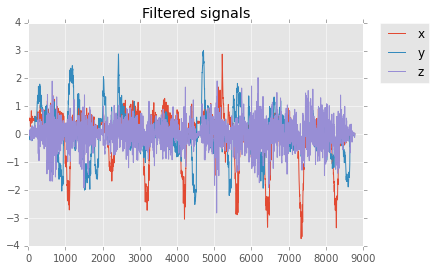

In [171]:
plt.plot(df_1['smooth_x'], label='x')
plt.plot(df_1['smooth_y'], label='y')
plt.plot(df_1['smooth_z'], label='z')
# plt.plot(df_1['forward_accel'], label='accel')
plt.title('Filtered signals')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

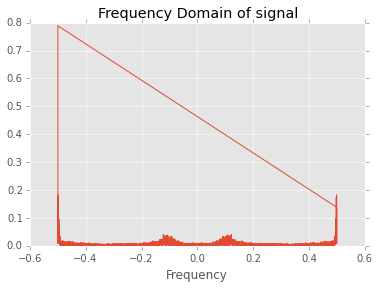

In [178]:
import scipy
# the Fourier transform of the input signal.
sig = df_1['x'] / n
FFT = abs(scipy.fft(sig))
FFT = scipy.fftpack.fftshift(FFT)
freqs = scipy.fftpack.fftfreq(sig.size)
plt.plot(freqs, FFT)
plt.title("Frequency Domain of signal")
plt.xlabel("Frequency")

In [179]:
v0 = 0
def calcualte_speed(df, accel_col, speed_col):
    """
    Calculate speed from a panda data frame
    """
    df[speed_col] = v0
    accel_l = df[accel_col].tolist()
    time_l = df['time_diff'].tolist()
    prev_speed = v0
    speeds = [0]*len(df)
    for i in xrange(len(df)):
        speed_val = prev_speed + float(time_l[i])/1000*accel_l[i]
        speeds[i] = speed_val
        prev_speed = speed_val
    df[speed_col] = np.array(speeds)
    return df
        
df_1 = calcualte_speed(df_1, 'forward_accel', 'velocity')
df_1 = calcualte_speed(df_1, 'smooth_y', 'velocity_y')
df_1 = calcualte_speed(df_1, 'smooth_x', 'velocity_x')
df_1 = calcualte_speed(df_1, 'smooth_z', 'velocity_z')



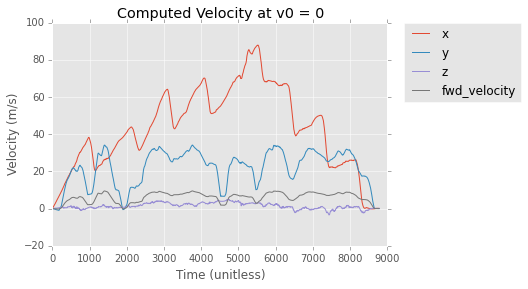

In [183]:
plt.plot(df_1['velocity_x']*3.6, label='x')
plt.plot(df_1['velocity_y']*3.6, label='y')
plt.plot(df_1['velocity_z']*3.6, label='z')
plt.plot(df_1['velocity'], label='fwd_velocity')
plt.title('Computed Velocity at v0 = 0')
plt.xlabel('Time (unitless)')
plt.ylabel('Velocity (m/s)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

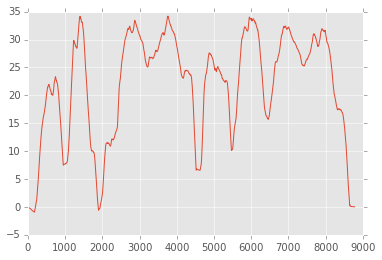

In [184]:
plt.plot(df_1['velocity']*3.6)